# 2kr Analysis (High Density Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## 2kr

In [9]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.995552,1.000000,0.999110,0.998221,0.994662,0.997331,0.996441,0.99911,0.999110,1.00000,0.997954,-0.002402,0.002046,0.001157,0.000267,-0.003292,-0.000623,-0.001512,0.001157,0.001157,0.002046
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,0.999110,1.000000,1.000000,1.000000,1.000000,1.000000,0.996441,1.00000,1.000000,1.00000,0.999555,-0.000445,0.000445,0.000445,0.000445,0.000445,0.000445,-0.003114,0.000445,0.000445,0.000445
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.000000,0.999110,1.000000,0.998221,0.998221,0.999110,0.999110,1.00000,0.999110,1.00000,0.999288,0.000712,-0.000178,0.000712,-0.001068,-0.001068,-0.000178,-0.000178,0.000712,-0.000178,0.000712
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.99911,0.999911,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,-0.000801
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.000000,1.000000,0.992883,1.000000,0.992883,1.000000,1.000000,0.99911,1.000000,1.00000,0.998488,0.001512,0.001512,-0.005605,0.001512,-0.005605,0.001512,0.001512,0.000623,0.001512,0.001512
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1.000000,0.996441,0.994662,1.000000,1.000000,1.000000,1.000000,1.00000,0.998221,1.00000,0.998932,0.001068,-0.002491,-0.004270,0.001068,0.001068,0.001068,0.001068,0.001068,-0.000712,0.001068
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,0.998221,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.99911,0.998221,1.00000,0.999555,-0.001335,0.000445,0.000445,0.000445,0.000445,0.000445,0.000445,-0.000445,-0.001335,0.000445


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.991281,0.003025,0.001423,0.004448,0.002669,0.0,-0.004093,-0.002669,0.002847,-0.003915,-0.000178,0.001068,-0.000356,0.002669,0.001423,0.000356,-0.004620,0.000709,-0.006398,0.005154,-0.006393,-0.002844,-0.000179,0.005154,0.001598,0.007819
Mean (Qi),0.999455,0.000189,0.000089,0.000278,0.000167,0.0,-0.000256,-0.000167,0.000178,-0.000245,-0.000011,0.000067,-0.000022,0.000167,0.000089,0.000022,-0.000289,0.000044,-0.000400,0.000322,-0.000400,-0.000178,-0.000011,0.000322,0.000100,0.000489
SSQ,,,,,,,,,,,,,,,,,0.000039,0.000021,0.000056,0.000007,0.000047,0.000026,0.000018,0.000005,0.000008,0.000011


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000006,0.000001,0.000012,0.000004,0.0,0.00001,0.000004,0.000005,0.00001,0.0,0.000001,0.0,0.000004,0.000001,0.0,0.000239
Variation,0.019115,0.004233,0.041339,0.014882,0.0,0.034989,0.014882,0.016932,0.032013,0.000066,0.002381,0.000265,0.014882,0.004233,0.000265,0.000299
Variation%,1.91%,0.42%,4.13%,1.49%,0.00%,3.50%,1.49%,1.69%,3.20%,0.01%,0.24%,0.03%,1.49%,0.42%,0.03%,79.95%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.00039,0.00029,0.000479,0.000368,0.000201,-0.000054,0.000035,0.000379,-0.000043,0.00019,0.000268,0.000179,0.000368,0.00029,0.000224
CI- Qi (95.00%),-0.000012,-0.000112,0.000077,-0.000035,-0.000201,-0.000457,-0.000368,-0.000023,-0.000446,-0.000213,-0.000135,-0.000224,-0.000035,-0.000112,-0.000179
Distance (Qi),0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403
Zero Included,True,True,False,True,True,False,True,True,False,True,True,True,True,True,True
CI+ Variation,0.081532,0.04509,0.122921,0.072508,0.021692,0.001582,0.00064,0.076954,0.001001,0.019362,0.038447,0.017165,0.072508,0.04509,0.026748
CI- Variation,0.000081,0.00676,0.00314,0.00064,0.021692,0.11178,0.072508,0.000294,0.106408,0.024154,0.009699,0.026748,0.00064,0.00676,0.017165
CI Distance (Variation),0.081451,0.03833,0.119781,0.071868,0.0,0.110198,0.071868,0.07666,0.105407,0.004791,0.028747,0.009582,0.071868,0.03833,0.009582


SSE = 0.00023920036473702234
SST = 0.0002991785501703321
Error variance = 1.6611136440070996e-06
Unexplained Variation = 79.95%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,619.0,564.0,679.0,572.0,531.0,656.0,731.0,612.0,613.0,662.0,623.9,-4.9,-59.9,55.1,-51.9,-92.9,32.1,107.1,-11.9,-10.9,38.1
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,418.0,353.0,394.0,373.0,379.0,352.0,452.0,436.0,356.0,373.0,388.6,29.4,-35.6,5.4,-15.6,-9.6,-36.6,63.4,47.4,-32.6,-15.6
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,996.0,972.0,986.0,1016.0,1040.0,997.0,970.0,1046.0,1017.0,944.0,998.4,-2.4,-26.4,-12.4,17.6,41.6,-1.4,-28.4,47.6,18.6,-54.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,547.0,616.0,624.0,594.0,638.0,603.0,551.0,575.0,616.0,583.0,594.7,-47.7,21.3,29.3,-0.7,43.3,8.3,-43.7,-19.7,21.3,-11.7
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,572.0,540.0,613.0,597.0,532.0,659.0,616.0,667.0,589.0,480.0,586.5,-14.5,-46.5,26.5,10.5,-54.5,72.5,29.5,80.5,2.5,-106.5
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,361.0,311.0,384.0,291.0,315.0,319.0,350.0,396.0,368.0,338.0,343.3,17.7,-32.3,40.7,-52.3,-28.3,-24.3,6.7,52.7,24.7,-5.3
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,945.0,975.0,935.0,891.0,1000.0,906.0,952.0,971.0,872.0,996.0,944.3,0.7,30.7,-9.3,-53.3,55.7,-38.3,7.7,26.7,-72.3,51.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,646.0,686.0,753.0,542.0,689.0,680.0,636.0,662.0,689.0,672.0,665.5,-19.5,20.5,87.5,-123.5,23.5,14.5,-29.5,-3.5,23.5,6.5
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3010.0,2670.0,2940.0,2908.0,2634.0,3087.0,2646.0,2388.0,3120.0,3062.0,2846.5,163.5,-176.5,93.5,61.5,-212.5,240.5,-200.5,-458.5,273.5,215.5


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,31484.9,21194.5,483.3,10335.5,-5610.7,615.3,7814.3,-3288.7,2367.5,814.9,-990.9,2168.7,580.9,-582.9,705.1,439.5,1.820641e+06,-2.878972e+06,1.325216e+06,2.435999e+06,-2.016758e+06,1.295669e+06,-983977.450000,-1.487342e+06,-2.306653e+06,2.796178e+06
Mean (Qi),1967.80625,1324.65625,30.20625,645.96875,-350.66875,38.45625,488.39375,-205.54375,147.96875,50.93125,-61.93125,135.54375,36.30625,-36.43125,44.06875,27.46875,1.137901e+05,-1.799357e+05,8.282598e+04,1.522499e+05,-1.260474e+05,8.097933e+04,-61498.590625,-9.295890e+04,-1.441658e+05,1.747611e+05
SSQ,,,,,,,,,,,,,,,,,1.643036e+05,3.615101e+05,9.976105e+04,2.308410e+05,3.906780e+05,2.191089e+05,253505.250000,5.413650e+05,2.571645e+05,2.998110e+05


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,280754268.90625,145986.80625,66764100.15625,19674971.55625,236621.30625,38164552.80625,6759717.30625,3503160.15625,415038.75625,613676.75625,2939537.30625,210903.00625,212357.75625,310728.75625,120725.15625,2818048.5
Variation,0.662712,0.000345,0.157595,0.046442,0.000559,0.090086,0.015956,0.008269,0.00098,0.001449,0.006939,0.000498,0.000501,0.000733,0.000285,423644394.99375
Variation%,66.27%,0.03%,15.76%,4.64%,0.06%,9.01%,1.60%,0.83%,0.10%,0.14%,0.69%,0.05%,0.05%,0.07%,0.03%,0.67%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),1346.516056,52.066056,667.828556,-328.808944,60.316056,510.253556,-183.683944,169.828556,72.791056,-40.071444,157.403556,58.166056,-14.571444,65.928556,49.328556
CI- Qi (95.00%),1302.796444,8.346444,624.108944,-372.528556,16.596444,466.533944,-227.403556,126.108944,29.071444,-83.791056,113.683944,14.446444,-58.291056,22.208944,5.608944
Distance (Qi),43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612,43.719612
Zero Included,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CI+ Variation,0.684765,0.001024,0.168441,0.040832,0.001374,0.098331,0.012743,0.010893,0.002001,0.000606,0.009357,0.001278,0.00008,0.001642,0.000919
CI- Variation,0.64102,0.000026,0.147109,0.052413,0.000104,0.082202,0.01953,0.006006,0.000319,0.002652,0.004881,0.000079,0.001283,0.000186,0.000012
CI Distance (Variation),0.043745,0.000998,0.021332,0.01158,0.00127,0.016129,0.006788,0.004886,0.001682,0.002045,0.004476,0.001199,0.001203,0.001455,0.000907


SSE = 2818048.5
SST = 423644394.99375004
Error variance = 19569.78125
Unexplained Variation = 0.67%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,756.0,730.0,789.0,769.0,774.0,761.0,777.0,787.0,776.0,794.0,771.3,-15.3,-41.3,17.7,-2.3,2.7,-10.3,5.7,15.7,4.7,22.7
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,823.0,796.0,788.0,777.0,805.0,788.0,811.0,801.0,788.0,807.0,798.4,24.6,-2.4,-10.4,-21.4,6.6,-10.4,12.6,2.6,-10.4,8.6
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1125.0,1124.0,1125.0,1123.0,1123.0,1124.0,1124.0,1125.0,1124.0,1125.0,1124.2,0.8,-0.2,0.8,-1.2,-1.2,-0.2,-0.2,0.8,-0.2,0.8
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1124.0,1124.9,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-0.9
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,751.0,713.0,736.0,741.0,704.0,739.0,743.0,711.0,709.0,706.0,725.3,25.7,-12.3,10.7,15.7,-21.3,13.7,17.7,-14.3,-16.3,-19.3
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,702.0,641.0,665.0,646.0,679.0,674.0,685.0,672.0,679.0,656.0,669.9,32.1,-28.9,-4.9,-23.9,9.1,4.1,15.1,2.1,9.1,-13.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1109.0,1113.0,1113.0,1119.0,1118.0,1117.0,1117.0,1120.0,1112.0,1111.0,1114.9,-5.9,-1.9,-1.9,4.1,3.1,2.1,2.1,5.1,-2.9,-3.9
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1106.0,1111.0,1104.0,1104.0,1117.0,1114.0,1108.0,1107.0,1118.0,1116.0,1110.5,-4.5,0.5,-6.5,-6.5,6.5,3.5,-2.5,-3.5,7.5,5.5
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,640.0,607.0,633.0,636.0,596.0,678.0,565.0,578.0,637.0,673.0,624.3,15.7,-17.3,8.7,11.7,-28.3,53.7,-59.3,-46.3,12.7,48.7


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,13977.7,-901.1,-655.1,3792.3,-173.7,-258.7,773.1,-109.7,434.7,-231.7,114.5,133.1,-56.5,65.3,166.9,12.1,57809.270000,-77967.530000,47660.570000,-60939.530000,-64135.230000,16386.870000,5301.970000,-24611.530000,-11869.130000,112364.270000
Mean (Qi),873.60625,-56.31875,-40.94375,237.01875,-10.85625,-16.16875,48.31875,-6.85625,27.16875,-14.48125,7.15625,8.31875,-3.53125,4.08125,10.43125,0.75625,3613.079375,-4872.970625,2978.785625,-3808.720625,-4008.451875,1024.179375,331.373125,-1538.220625,-741.820625,7022.766875
SSQ,,,,,,,,,,,,,,,,,5063.830000,4103.430000,2247.230000,2995.430000,12539.830000,4390.630000,5391.430000,5810.430000,3499.630000,9328.830000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,507488.25625,268222.50625,8988462.05625,18857.30625,41828.55625,373552.25625,7521.30625,118102.55625,33553.05625,8193.90625,11072.25625,1995.15625,2665.05625,17409.75625,91.50625,55370.7
Variation,0.048543,0.025656,0.859779,0.001804,0.004001,0.035732,0.000719,0.011297,0.003209,0.000784,0.001059,0.000191,0.000255,0.001665,0.000009,10454386.19375
Variation%,4.85%,2.57%,85.98%,0.18%,0.40%,3.57%,0.07%,1.13%,0.32%,0.08%,0.11%,0.02%,0.03%,0.17%,0.00%,0.53%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-53.254585,-37.879585,240.082915,-7.792085,-13.104585,51.382915,-3.792085,30.232915,-11.417085,10.220415,11.382915,-0.467085,7.145415,13.495415,3.820415
CI- Qi (95.00%),-59.382915,-44.007915,233.954585,-13.920415,-19.232915,45.254585,-9.920415,24.104585,-17.545415,4.092085,5.254585,-6.595415,1.017085,7.367085,-2.307915
Distance (Qi),6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329,6.128329
Zero Included,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
CI+ Variation,0.043405,0.02196,0.882153,0.000929,0.002628,0.040407,0.00022,0.013989,0.001995,0.001599,0.001983,0.000003,0.000781,0.002787,0.000223
CI- Variation,0.053969,0.02964,0.837692,0.002966,0.005661,0.031343,0.001506,0.008892,0.004711,0.000256,0.000423,0.000666,0.000016,0.000831,0.000082
CI Distance (Variation),0.010564,0.00768,0.044461,0.002036,0.003033,0.009064,0.001286,0.005096,0.002716,0.001342,0.00156,0.000662,0.000766,0.001957,0.000142


SSE = 55370.7
SST = 10454386.193750003
Error variance = 384.51874999999995
Unexplained Variation = 0.53%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.127134,3.637586,4.248495,4.276666,4.189655,3.610918,3.637586,3.737670,3.988984,3.663562,3.911826,0.215309,-0.274239,0.336670,0.364841,0.277829,-0.300908,-0.274239,-0.174156,0.077158,-0.248264
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,3.871201,3.784190,3.737670,4.025352,3.970292,4.060443,4.418841,3.871201,3.828641,4.189655,3.975748,-0.104547,-0.191559,-0.238079,0.049603,-0.005457,0.084695,0.443092,-0.104547,-0.147107,0.213906
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,3.526361,3.871201,4.043051,4.007333,3.583519,4.234107,4.043051,3.688879,3.555348,3.713572,3.826642,-0.300282,0.044559,0.216409,0.180691,-0.243123,0.407464,0.216409,-0.137763,-0.271294,-0.113070
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,3.663562,3.871201,3.688879,3.988984,3.784190,4.276666,4.043051,3.784190,3.891820,3.871201,3.886374,-0.222813,-0.015173,-0.197495,0.102610,-0.102185,0.390292,0.156677,-0.102185,0.005446,-0.015173
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.317488,4.454347,4.127134,4.875197,4.477337,4.204693,4.812184,4.127134,4.406719,4.330733,4.413297,-0.095809,0.041051,-0.286162,0.461901,0.064040,-0.208604,0.398888,-0.286162,-0.006578,-0.082563
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.174387,4.304065,4.234107,4.521789,4.290459,4.418841,4.919981,4.653960,4.290459,4.859812,4.466786,-0.292399,-0.162721,-0.232680,0.055003,-0.176327,-0.047945,0.453195,0.187174,-0.176327,0.393026
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.595120,4.077537,4.454347,4.110874,4.521789,4.127134,4.406719,4.290459,4.477337,4.430817,4.349213,0.245906,-0.271676,0.105134,-0.238340,0.172575,-0.222079,0.057506,-0.058754,0.128123,0.081603
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.204693,4.276666,4.234107,4.343805,4.304065,4.382027,4.709530,4.543295,4.219508,4.700480,4.391818,-0.187125,-0.115151,-0.157711,-0.048012,-0.087752,-0.009791,0.317713,0.151477,-0.172310,0.308663
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,2.995732,2.772589,3.258097,3.295837,2.995732,2.772589,2.639057,2.995732,3.044522,2.833213,2.960310,0.035422,-0.187721,0.297786,0.335527,0.035422,-0.187721,-0.321253,0.035422,0.084212,-0.127097


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,58.075509,-8.3679,3.706985,-0.717105,0.304069,-0.334061,-0.089886,-0.135428,0.12848,-0.022855,-0.080393,0.057469,0.032268,-0.050242,-0.170294,-0.156905,-2.889108,-6.687656,-1.064811,3.474172,1.240513,-1.001773,8.159129,-2.768206,-1.952783,3.490521
Mean (Qi),3.629719,-0.522994,0.231687,-0.044819,0.019004,-0.020879,-0.005618,-0.008464,0.00803,-0.001428,-0.005025,0.003592,0.002017,-0.00314,-0.010643,-0.009807,-0.180569,-0.417978,-0.066551,0.217136,0.077532,-0.062611,0.509946,-0.173013,-0.122049,0.218158
SSQ,,,,,,,,,,,,,,,,,0.604586,0.341211,0.652356,0.726583,0.475598,0.836684,1.137667,0.394371,0.250622,0.955573


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,43.763589,8.588586,0.3214,0.057786,0.069748,0.00505,0.011463,0.010317,0.000326,0.004039,0.002064,0.000651,0.001578,0.018125,0.015387,6.375251
Variation,0.738684,0.144966,0.005425,0.000975,0.001177,0.000085,0.000193,0.000174,0.000006,0.000068,0.000035,0.000011,0.000027,0.000306,0.00026,59.24536
Variation%,73.87%,14.50%,0.54%,0.10%,0.12%,0.01%,0.02%,0.02%,0.00%,0.01%,0.00%,0.00%,0.00%,0.03%,0.03%,10.76%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.490115,0.264566,-0.01194,0.051883,0.012,0.027261,0.024415,0.040909,0.031451,0.027855,0.036471,0.034896,0.029739,0.022236,0.023073
CI- Qi (95.00%),-0.555873,0.198807,-0.077698,-0.013875,-0.053758,-0.038497,-0.041343,-0.024849,-0.034308,-0.037904,-0.029287,-0.030862,-0.036019,-0.043523,-0.042686
Distance (Qi),0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758,0.065758
Zero Included,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.648725,0.189031,0.000385,0.00727,0.000389,0.002007,0.00161,0.00452,0.002671,0.002095,0.003592,0.003289,0.002388,0.001335,0.001438
CI- Variation,0.834481,0.106741,0.016304,0.00052,0.007805,0.004002,0.004616,0.001668,0.003179,0.00388,0.002316,0.002572,0.003504,0.005116,0.004921
CI Distance (Variation),0.185756,0.08229,0.015919,0.00675,0.007416,0.001995,0.003006,0.002852,0.000507,0.001785,0.001276,0.000716,0.001115,0.00378,0.003483


SSE = 6.375251419538806
SST = 59.24535997677867
Error variance = 0.044272579302352816
Unexplained Variation = 10.76%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.543295,4.007333,4.663439,4.653960,4.605170,4.007333,4.043051,4.248495,4.418841,4.276666,4.346758,0.196536,-0.339425,0.316681,0.307202,0.258412,-0.339425,-0.303707,-0.098263,0.072082,-0.070092
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.234107,4.158883,4.219508,4.477337,4.382027,4.584967,4.787492,4.356709,4.356709,4.653960,4.421170,-0.187063,-0.262287,-0.201662,0.056167,-0.039143,0.163798,0.366322,-0.064461,-0.064461,0.232791
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,3.951244,4.394449,4.521789,4.418841,4.025352,4.624973,4.488636,4.094345,4.007333,4.276666,4.280363,-0.329119,0.114086,0.241426,0.138478,-0.255011,0.344610,0.208274,-0.186018,-0.273029,-0.003697
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.290459,4.343805,4.189655,4.406719,4.430817,4.682131,4.553877,4.219508,4.304065,4.356709,4.377775,-0.087315,-0.033969,-0.188120,0.028945,0.053042,0.304357,0.176102,-0.158267,-0.073709,-0.021066
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.770685,5.010635,4.663439,5.214936,4.836282,4.644391,5.247024,4.634729,4.787492,5.049856,4.885947,-0.115262,0.124688,-0.222508,0.328989,-0.049665,-0.241556,0.361077,-0.251218,-0.098455,0.163909
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.770685,4.682131,4.605170,5.043425,4.691348,4.997212,5.313206,5.187386,4.653960,5.303305,4.924783,-0.154098,-0.242652,-0.319613,0.118642,-0.233435,0.072429,0.388423,0.262603,-0.270822,0.378522
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.003946,4.584967,4.882802,4.682131,4.897840,4.795791,4.919981,4.753590,4.882802,4.969813,4.837366,0.166580,-0.252399,0.045436,-0.155235,0.060473,-0.041576,0.082615,-0.083776,0.045436,0.132447
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.753590,4.691348,4.744932,4.836282,4.897840,4.836282,5.176150,5.017280,4.718499,5.087596,4.875980,-0.122390,-0.184632,-0.131048,-0.039698,0.021860,-0.039698,0.300170,0.141300,-0.157481,0.211616
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.465736,3.433987,3.737670,3.713572,3.526361,3.258097,3.044522,3.401197,3.526361,3.332205,3.443971,0.021765,-0.009983,0.293699,0.269601,0.082390,-0.185874,-0.399448,-0.042773,0.082390,-0.111766


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,65.878582,-8.0217,3.887442,-0.714482,0.485612,-0.308579,-0.300133,-0.012933,0.171322,-0.223202,0.068473,0.146506,-0.034455,0.022917,-0.08923,-0.042785,-2.288407,-8.651044,0.095622,2.927520,1.091734,0.723610,7.214970,-2.091254,-3.976559,4.953807
Mean (Qi),4.117411,-0.501356,0.242965,-0.044655,0.030351,-0.019286,-0.018758,-0.000808,0.010708,-0.01395,0.00428,0.009157,-0.002153,0.001432,-0.005577,-0.002674,-0.143025,-0.540690,0.005976,0.182970,0.068233,0.045226,0.450936,-0.130703,-0.248535,0.309613
SSQ,,,,,,,,,,,,,,,,,0.503721,0.562460,0.712022,0.571837,0.319211,0.703161,1.056677,0.358123,0.346583,0.797945


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,40.217296,9.445129,0.319053,0.147387,0.059513,0.0563,0.000105,0.018344,0.031137,0.00293,0.013415,0.000742,0.000328,0.004976,0.001144,5.93174
Variation,0.71498,0.167915,0.005672,0.00262,0.001058,0.001001,0.000002,0.000326,0.000554,0.000052,0.000238,0.000013,0.000006,0.000088,0.00002,56.249541
Variation%,71.50%,16.79%,0.57%,0.26%,0.11%,0.10%,0.00%,0.03%,0.06%,0.01%,0.02%,0.00%,0.00%,0.01%,0.00%,10.55%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.469641,0.27468,-0.01294,0.062066,0.012429,0.012957,0.030907,0.042422,0.017765,0.035994,0.040872,0.029561,0.033147,0.026138,0.029041
CI- Qi (95.00%),-0.533071,0.21125,-0.07637,-0.001364,-0.051001,-0.050473,-0.032523,-0.021007,-0.045665,-0.027435,-0.022558,-0.033868,-0.030283,-0.037292,-0.034389
Distance (Qi),0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343,0.06343
Zero Included,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.627384,0.214613,0.000476,0.010957,0.000439,0.000478,0.002717,0.005119,0.000898,0.003685,0.004752,0.002486,0.003125,0.001943,0.002399
CI- Variation,0.808298,0.126939,0.01659,0.000005,0.007399,0.007246,0.003009,0.001255,0.005932,0.002141,0.001447,0.003263,0.002608,0.003956,0.003364
CI Distance (Variation),0.180913,0.087673,0.016114,0.010952,0.006959,0.006769,0.000292,0.003864,0.005034,0.001544,0.003304,0.000777,0.000517,0.002012,0.000965


SSE = 5.93174042845882
SST = 56.24954102458414
Error variance = 0.04119264186429736
Unexplained Variation = 10.55%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.844187,4.330733,4.897840,4.867534,4.844187,4.290459,4.418841,4.584967,4.682131,4.584967,4.634585,0.209602,-0.303851,0.263255,0.232950,0.209602,-0.344125,-0.215744,-0.049617,0.047546,-0.049617
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.430817,4.418841,4.543295,4.795791,4.709530,4.844187,4.990433,4.691348,4.691348,4.948760,4.706435,-0.275618,-0.287594,-0.163140,0.089356,0.003095,0.137752,0.283998,-0.015087,-0.015087,0.242325
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.204693,4.634729,4.744932,4.663439,4.234107,4.836282,4.736198,4.442651,4.330733,4.605170,4.543293,-0.338601,0.091436,0.201639,0.120146,-0.309187,0.292988,0.192905,-0.100642,-0.212560,0.061877
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.564348,4.605170,4.543295,4.762174,4.718499,4.882802,4.804021,4.553877,4.624973,4.718499,4.677766,-0.113418,-0.072596,-0.134471,0.084408,0.040733,0.205036,0.126255,-0.123889,-0.052793,0.040733
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.093750,5.257495,5.036953,5.459586,5.135798,4.919981,5.438079,4.983607,5.147494,5.257495,5.173024,-0.079274,0.084471,-0.136071,0.286562,-0.037225,-0.253043,0.265055,-0.189417,-0.025529,0.084471
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.164786,4.875197,4.852030,5.402677,4.934474,5.257495,5.579730,5.389072,4.934474,5.525453,5.191539,-0.026753,-0.316342,-0.339509,0.211139,-0.257065,0.065957,0.388191,0.197533,-0.257065,0.333914
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.257495,4.934474,5.204007,5.010635,5.187386,5.081404,5.164786,5.068904,5.209486,5.192957,5.131153,0.126342,-0.196680,0.072853,-0.120518,0.056232,-0.049749,0.033633,-0.062249,0.078333,0.061803
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.062595,5.023881,5.105945,5.170484,5.176150,5.181784,5.393628,5.318120,5.068904,5.313206,5.181470,-0.118875,-0.157589,-0.075524,-0.010986,-0.005320,0.000314,0.212158,0.136650,-0.112565,0.131736
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.806662,3.761200,3.970292,3.970292,3.828641,3.637586,3.295837,3.737670,3.871201,3.637586,3.751697,0.054966,0.009503,0.218595,0.218595,0.076945,-0.114111,-0.455860,-0.014027,0.119504,-0.114111


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,70.699132,-7.779398,3.953283,-0.705986,0.550674,-0.276931,-0.362186,0.000368,0.163604,-0.253754,0.192045,0.027562,0.021228,0.003198,-0.087197,-0.025554,-2.518894,-9.311572,0.454088,4.114407,1.027238,-0.077555,6.269514,-0.833226,-2.961678,3.837678
Mean (Qi),4.418696,-0.486212,0.24708,-0.044124,0.034417,-0.017308,-0.022637,0.000023,0.010225,-0.01586,0.012003,0.001723,0.001327,0.0002,-0.00545,-0.001597,-0.157431,-0.581973,0.028381,0.257150,0.064202,-0.004847,0.391845,-0.052077,-0.185105,0.239855
SSQ,,,,,,,,,,,,,,,,,0.507785,0.539261,0.479017,0.409221,0.336941,0.565021,0.799210,0.251057,0.318089,0.592214


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,37.824391,9.767777,0.31151,0.189526,0.047932,0.081987,0.0,0.016729,0.040244,0.023051,0.000475,0.000282,0.000006,0.004752,0.000408,4.797816
Variation,0.712231,0.183927,0.005866,0.003569,0.000903,0.001544,0.0,0.000315,0.000758,0.000434,0.000009,0.000005,0.0,0.000089,0.000008,53.106887
Variation%,71.22%,18.39%,0.59%,0.36%,0.09%,0.15%,0.00%,0.03%,0.08%,0.04%,0.00%,0.00%,0.00%,0.01%,0.00%,9.03%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.457689,0.275603,-0.015601,0.06294,0.011215,0.005886,0.028546,0.038748,0.012663,0.040526,0.030246,0.02985,0.028723,0.023073,0.026926
CI- Qi (95.00%),-0.514735,0.218557,-0.072647,0.005894,-0.045831,-0.05116,-0.0285,-0.018298,-0.044383,-0.01652,-0.0268,-0.027196,-0.028323,-0.033973,-0.03012
Distance (Qi),0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046,0.057046
Zero Included,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.631118,0.228843,0.000733,0.011935,0.000379,0.000104,0.002455,0.004523,0.000483,0.004948,0.002756,0.002684,0.002486,0.001604,0.002184
CI- Variation,0.798246,0.143913,0.0159,0.000105,0.006328,0.007885,0.002447,0.001009,0.005935,0.000822,0.002164,0.002228,0.002417,0.003477,0.002733
CI Distance (Variation),0.167128,0.08493,0.015167,0.01183,0.005949,0.007781,0.000008,0.003515,0.005451,0.004126,0.000592,0.000456,0.000069,0.001873,0.000549


SSE = 4.797815839487713
SST = 53.10688668991184
Error variance = 0.03331816555199801
Unexplained Variation = 9.03%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.036953,4.584967,5.023881,5.043425,4.969813,4.465908,4.615121,4.779123,4.852030,4.762174,4.813340,0.223613,-0.228372,0.210541,0.230086,0.156474,-0.347431,-0.198219,-0.034216,0.038691,-0.051166
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.595120,4.564348,4.770685,4.969813,4.912655,4.997212,5.111988,4.812184,4.927254,5.105945,4.876720,-0.281601,-0.312372,-0.106036,0.093093,0.035934,0.120492,0.235267,-0.064536,0.050533,0.229225
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.382027,4.795791,4.897840,4.812184,4.382027,4.955827,4.890349,4.624973,4.564348,4.795791,4.710116,-0.328089,0.085675,0.187724,0.102069,-0.328089,0.245711,0.180234,-0.085143,-0.145767,0.085675
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.762174,4.779123,4.753590,4.934474,4.890349,5.023881,4.948760,4.718499,4.820282,4.890349,4.852148,-0.089974,-0.073025,-0.098558,0.082326,0.038201,0.171732,0.096612,-0.133649,-0.031867,0.038201
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.308268,5.389072,5.192957,5.568345,5.298317,5.123964,5.549076,5.135798,5.327876,5.384495,5.327817,-0.019549,0.061255,-0.134860,0.240528,-0.029499,-0.203853,0.221259,-0.192018,0.000059,0.056678
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.323010,5.049856,5.017280,5.572154,5.081404,5.416100,5.707110,5.545177,5.093750,5.676754,5.348260,-0.025250,-0.298404,-0.330980,0.223894,-0.266855,0.067841,0.358851,0.196918,-0.254509,0.328494
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.398163,5.093750,5.351858,5.176150,5.351858,5.247024,5.337538,5.236442,5.370638,5.361292,5.292471,0.105691,-0.198721,0.059387,-0.116322,0.059387,-0.045447,0.045067,-0.056029,0.078167,0.068821
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.231109,5.181784,5.303305,5.332719,5.318120,5.347108,5.513429,5.476464,5.283204,5.442418,5.342966,-0.111857,-0.161182,-0.039661,-0.010247,-0.024846,0.004142,0.170463,0.133498,-0.059762,0.099452
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.988984,3.970292,4.094345,4.143135,3.970292,3.850148,3.496508,3.931826,4.043051,3.806662,3.929524,0.059460,0.040768,0.164820,0.213611,0.040768,-0.079377,-0.433017,0.002301,0.113527,-0.122862


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,73.490048,-7.637626,3.914412,-0.752331,0.529752,-0.203967,-0.41546,-0.022949,0.15576,-0.262177,0.18943,-0.018554,0.006775,-0.027976,-0.061682,0.035518,-1.899486,-8.683135,0.540971,3.856274,0.305898,-0.234522,5.367286,-0.885548,-1.612234,3.244495
Mean (Qi),4.593128,-0.477352,0.244651,-0.047021,0.03311,-0.012748,-0.025966,-0.001434,0.009735,-0.016386,0.011839,-0.00116,0.000423,-0.001748,-0.003855,0.00222,-0.118718,-0.542696,0.033811,0.241017,0.019119,-0.014658,0.335455,-0.055347,-0.100765,0.202781
SSQ,,,,,,,,,,,,,,,,,0.500218,0.455525,0.368655,0.379164,0.306289,0.441362,0.676416,0.250115,0.298250,0.491595


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,36.458333,9.57664,0.353751,0.175398,0.026002,0.107879,0.000329,0.015163,0.04296,0.022427,0.000215,0.000029,0.000489,0.002378,0.000788,4.167588
Variation,0.715566,0.18796,0.006943,0.003443,0.00051,0.002117,0.000006,0.000298,0.000843,0.00044,0.000004,0.000001,0.00001,0.000047,0.000015,50.950371
Variation%,71.56%,18.80%,0.69%,0.34%,0.05%,0.21%,0.00%,0.03%,0.08%,0.04%,0.00%,0.00%,0.00%,0.00%,0.00%,8.18%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.450768,0.271234,-0.020437,0.059693,0.013836,0.000617,0.025149,0.036319,0.010198,0.038423,0.025424,0.027007,0.024835,0.022729,0.028804
CI- Qi (95.00%),-0.503935,0.218067,-0.073604,0.006526,-0.039332,-0.05255,-0.028018,-0.016849,-0.04297,-0.014744,-0.027743,-0.02616,-0.028332,-0.030439,-0.024364
Distance (Qi),0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167,0.053167
Zero Included,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.638085,0.231027,0.001312,0.01119,0.000601,0.000001,0.001986,0.004142,0.000327,0.004636,0.00203,0.00229,0.001937,0.001622,0.002605
CI- Variation,0.797484,0.149332,0.017013,0.000134,0.004858,0.008672,0.002465,0.000891,0.005798,0.000683,0.002417,0.002149,0.002521,0.00291,0.001864
CI Distance (Variation),0.159399,0.081695,0.015701,0.011056,0.004257,0.008671,0.000479,0.003251,0.005472,0.003953,0.000387,0.000141,0.000584,0.001287,0.000741


SSE = 4.167588206698097
SST = 50.950371475567025
Error variance = 0.028941584768736785
Unexplained Variation = 8.18%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.093750,4.672829,5.087596,5.117994,5.056246,4.553877,4.691348,4.836282,4.919981,4.852030,4.888193,0.205557,-0.215364,0.199403,0.229801,0.168053,-0.334316,-0.196845,-0.051911,0.031788,-0.036163
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.653960,4.634729,4.859812,5.056246,4.990433,5.111988,5.176150,4.852030,4.990433,5.159055,4.948484,-0.294523,-0.313755,-0.088671,0.107762,0.041949,0.163504,0.227666,-0.096453,0.041949,0.210572
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.442651,4.859812,4.955827,4.890349,4.465908,5.023881,4.962845,4.700480,4.624973,4.905275,4.783200,-0.340549,0.076612,0.172627,0.107149,-0.317292,0.240680,0.179645,-0.082720,-0.158227,0.122075
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.820282,4.844187,4.828314,4.976734,4.962845,5.153292,5.003946,4.787492,4.912655,4.955827,4.924557,-0.104276,-0.080370,-0.096243,0.052177,0.038287,0.228734,0.079389,-0.137065,-0.011902,0.031270
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.375278,5.480639,5.298317,5.655992,5.361292,5.198497,5.602119,5.214936,5.389072,5.446737,5.402288,-0.027010,0.078351,-0.103971,0.253704,-0.040996,-0.203791,0.199831,-0.187352,-0.013216,0.044449
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.459586,5.153292,5.117994,5.638355,5.147494,5.476464,5.762051,5.655992,5.153292,5.743003,5.430752,0.028833,-0.277461,-0.312758,0.207603,-0.283258,0.045711,0.331299,0.225240,-0.277461,0.312251
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.484797,5.159055,5.402677,5.293305,5.416100,5.298317,5.451038,5.313206,5.398163,5.433722,5.365038,0.119759,-0.205983,0.037639,-0.071733,0.051062,-0.066721,0.086000,-0.051832,0.033125,0.068684
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.298317,5.257495,5.365976,5.420535,5.402677,5.416100,5.575949,5.537334,5.318120,5.517453,5.410996,-0.112678,-0.153500,-0.045020,0.009539,-0.008318,0.005105,0.164953,0.126338,-0.092876,0.106457
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.060443,4.043051,4.189655,4.189655,4.094345,3.912023,3.583519,3.988984,4.077537,3.891820,4.003103,0.057340,0.039948,0.186552,0.186552,0.091241,-0.091080,-0.419584,-0.014119,0.074434,-0.111283


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,74.707562,-7.599454,3.909327,-0.790283,0.528025,-0.219953,-0.418432,-0.024113,0.130809,-0.267909,0.154338,-0.013018,-0.013457,-0.042783,-0.052641,0.074506,-1.147436,-8.401086,0.471256,3.768526,0.824536,-0.041597,4.893024,-1.063321,-2.774588,3.470687
Mean (Qi),4.669223,-0.474966,0.244333,-0.049393,0.033002,-0.013747,-0.026152,-0.001507,0.008176,-0.016744,0.009646,-0.000814,-0.000841,-0.002674,-0.00329,0.004657,-0.071715,-0.525068,0.029454,0.235533,0.051533,-0.002600,0.305814,-0.066458,-0.173412,0.216918
SSQ,,,,,,,,,,,,,,,,,0.529316,0.431836,0.332276,0.350258,0.327670,0.449580,0.642613,0.257721,0.310527,0.482739


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,36.094813,9.551774,0.390342,0.174257,0.030237,0.109428,0.000363,0.010694,0.044859,0.014888,0.000106,0.000113,0.001144,0.001732,0.003469,4.114536
Variation,0.714144,0.188984,0.007723,0.003448,0.000598,0.002165,0.000007,0.000212,0.000888,0.000295,0.000002,0.000002,0.000023,0.000034,0.000069,50.542757
Variation%,71.41%,18.90%,0.77%,0.34%,0.06%,0.22%,0.00%,0.02%,0.09%,0.03%,0.00%,0.00%,0.00%,0.00%,0.01%,8.14%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.448552,0.270747,-0.022979,0.059415,0.012667,0.000262,0.024907,0.034589,0.00967,0.03606,0.0256,0.025573,0.02374,0.023124,0.031071
CI- Qi (95.00%),-0.50138,0.217919,-0.075807,0.006588,-0.040161,-0.052566,-0.027921,-0.018238,-0.043158,-0.016768,-0.027228,-0.027255,-0.029088,-0.029704,-0.021757
Distance (Qi),0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828,0.052828
Zero Included,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.636923,0.232053,0.001672,0.011175,0.000508,0.0,0.001964,0.003787,0.000296,0.004116,0.002075,0.00207,0.001784,0.001693,0.003056
CI- Variation,0.795783,0.150332,0.018192,0.000137,0.005106,0.008747,0.002468,0.001053,0.005896,0.00089,0.002347,0.002352,0.002678,0.002793,0.001499
CI Distance (Variation),0.158861,0.081721,0.01652,0.011038,0.004598,0.008747,0.000504,0.002734,0.0056,0.003226,0.000272,0.000281,0.000894,0.0011,0.001557


SSE = 4.1145359936056
SST = 50.542756682390745
Error variance = 0.028573166622261108
Unexplained Variation = 8.14%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.187386,4.736198,5.209486,5.231109,5.159055,4.744932,4.795791,4.897840,5.176150,4.969813,5.010776,0.176610,-0.274578,0.198710,0.220333,0.148279,-0.265844,-0.214985,-0.112936,0.165374,-0.040963
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.795791,4.736198,5.010635,5.147494,5.056246,5.164786,5.247024,4.948760,5.068904,5.214936,5.039077,-0.243287,-0.302879,-0.028442,0.108417,0.017168,0.125709,0.207947,-0.090318,0.029827,0.175858
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.510860,4.955827,5.049856,5.030438,4.605170,5.129899,5.049856,4.828314,4.770685,4.983607,4.891451,-0.380592,0.064376,0.158405,0.138987,-0.286281,0.238448,0.158405,-0.063137,-0.120766,0.092156
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.969813,4.927254,4.912655,5.056246,5.111988,5.283204,5.049856,4.912655,5.023881,5.056246,5.030380,-0.060566,-0.103126,-0.117725,0.025866,0.081608,0.252824,0.019476,-0.117725,-0.006499,0.025866
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.433722,5.579730,5.407172,5.743003,5.484797,5.283204,5.690359,5.356586,5.455321,5.537334,5.497123,-0.063401,0.082607,-0.089951,0.245880,-0.012326,-0.213919,0.193237,-0.140537,-0.041802,0.040211
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.556828,5.283204,5.303305,5.686975,5.225747,5.560682,5.855072,5.723585,5.236442,5.840642,5.527248,0.029580,-0.244044,-0.223943,0.159727,-0.301501,0.033434,0.327824,0.196337,-0.290806,0.313394
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.583496,5.278115,5.463832,5.407172,5.476464,5.375278,5.537334,5.407172,5.451038,5.501258,5.448116,0.135380,-0.170001,0.015716,-0.040944,0.028348,-0.072838,0.089218,-0.040944,0.002923,0.053142
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.398163,5.375278,5.480639,5.513429,5.501258,5.556828,5.703782,5.638355,5.429346,5.587249,5.518433,-0.120270,-0.143154,-0.037794,-0.005004,-0.017174,0.038395,0.185350,0.119922,-0.089087,0.068816
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.110874,4.158883,4.290459,4.330733,4.174387,4.007333,3.713572,4.110874,4.219508,3.970292,4.108692,0.002182,0.050192,0.181768,0.222042,0.065696,-0.101358,-0.395120,0.002182,0.110816,-0.138400


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,76.525983,-7.399225,3.850606,-0.78278,0.479302,-0.187865,-0.41109,-0.056042,0.038902,-0.15584,0.102646,-0.101499,-0.022264,-0.198991,0.008822,0.149693,-1.312076,-8.574345,1.294697,3.487139,0.437961,1.005071,3.918956,-1.117808,-2.542252,3.402656
Mean (Qi),4.782874,-0.462452,0.240663,-0.048924,0.029956,-0.011742,-0.025693,-0.003503,0.002431,-0.00974,0.006415,-0.006344,-0.001392,-0.012437,0.000551,0.009356,-0.082005,-0.535897,0.080919,0.217946,0.027373,0.062817,0.244935,-0.069863,-0.158891,0.212666
SSQ,,,,,,,,,,,,,,,,,0.504489,0.423021,0.288051,0.316631,0.294953,0.389852,0.578976,0.192518,0.322007,0.507972


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,34.217829,9.266978,0.382965,0.143582,0.022058,0.105622,0.001963,0.000946,0.015179,0.006585,0.006439,0.00031,0.024748,0.000049,0.014005,3.81847
Variation,0.71246,0.192951,0.007974,0.00299,0.000459,0.002199,0.000041,0.00002,0.000316,0.000137,0.000134,0.000006,0.000515,0.000001,0.000292,48.027727
Variation%,71.25%,19.30%,0.80%,0.30%,0.05%,0.22%,0.00%,0.00%,0.03%,0.01%,0.01%,0.00%,0.05%,0.00%,0.03%,7.95%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.437006,0.266109,-0.023478,0.055402,0.013704,-0.000247,0.021943,0.027877,0.015706,0.031861,0.019102,0.024054,0.013009,0.025997,0.034802
CI- Qi (95.00%),-0.487897,0.215217,-0.07437,0.004511,-0.037187,-0.051139,-0.028948,-0.023014,-0.035186,-0.01903,-0.03179,-0.026837,-0.037883,-0.024894,-0.01609
Distance (Qi),0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892,0.050892
Zero Included,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True
CI+ Variation,0.636212,0.23591,0.001836,0.010225,0.000626,0.0,0.001604,0.002589,0.000822,0.003382,0.001216,0.001928,0.000564,0.002252,0.004035
CI- Variation,0.793021,0.154305,0.018425,0.000068,0.004607,0.008712,0.002792,0.001765,0.004124,0.001206,0.003367,0.002399,0.004781,0.002065,0.000862
CI Distance (Variation),0.156809,0.081604,0.016589,0.010158,0.003981,0.008712,0.001188,0.000824,0.003303,0.002175,0.002151,0.000472,0.004217,0.000187,0.003172


SSE = 3.8184695416426866
SST = 48.027726628061316
Error variance = 0.02651714959474088
Unexplained Variation = 7.95%

####################################



## Performance plot

Plotting with R on the x axis...


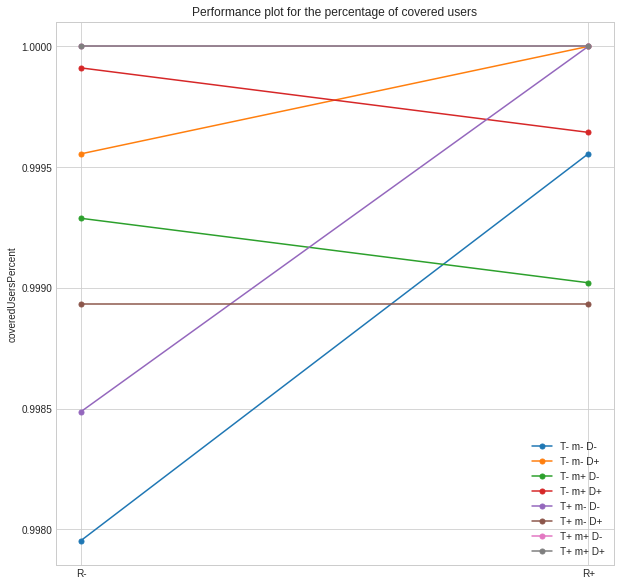

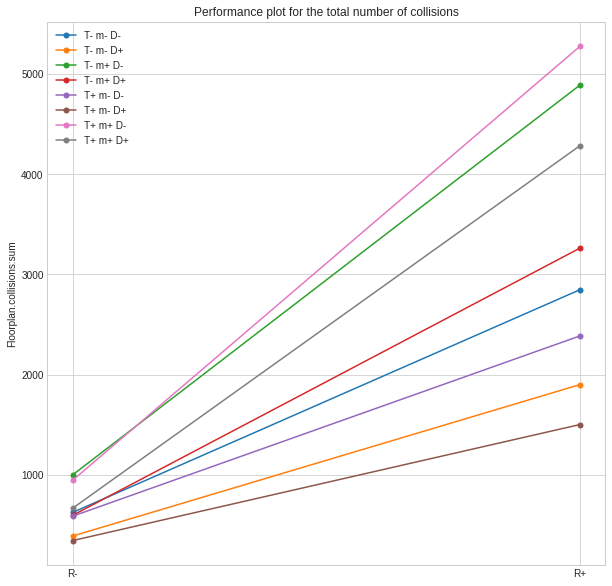

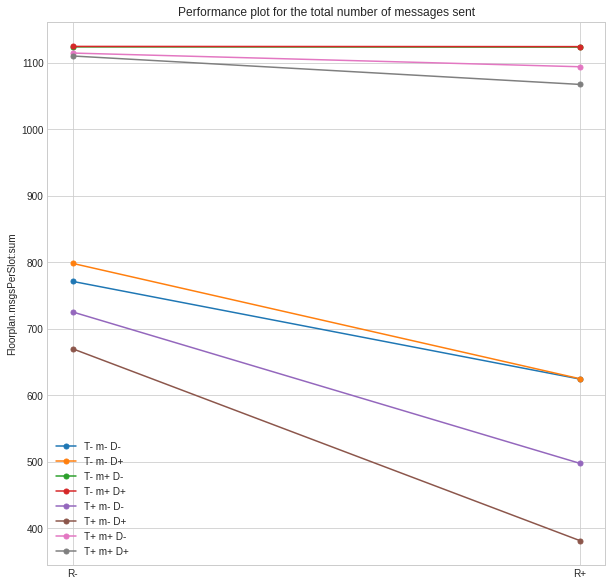

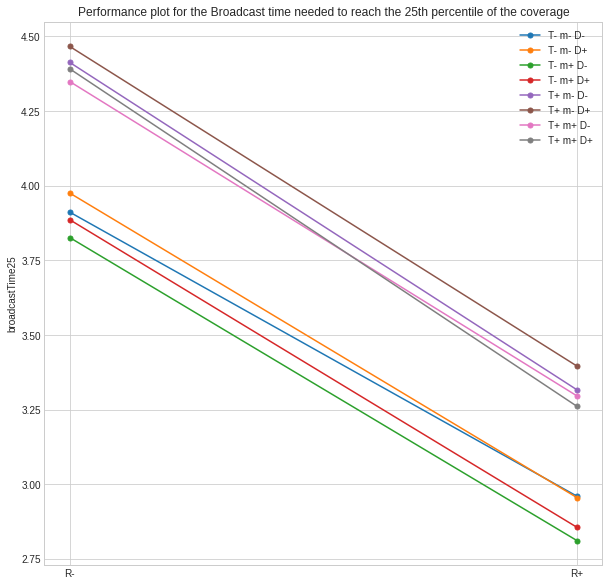

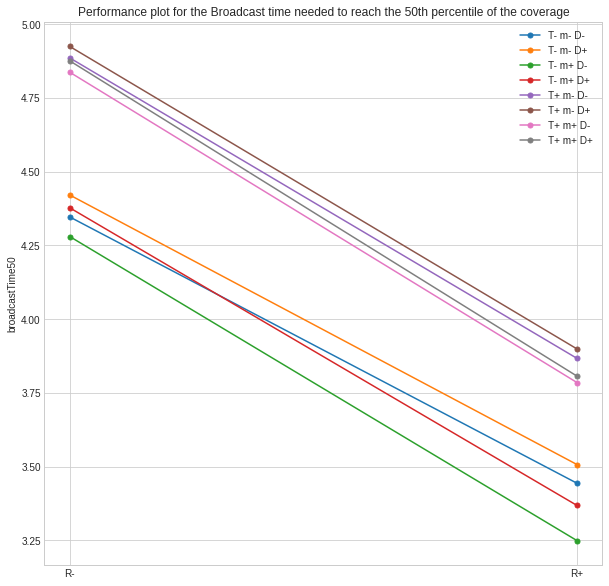

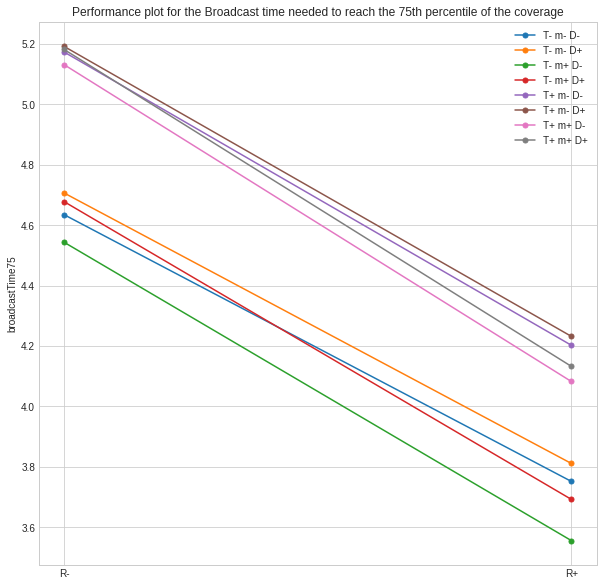

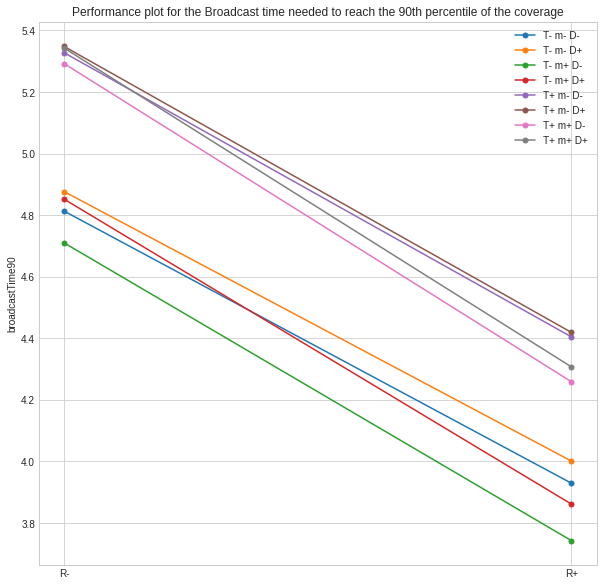

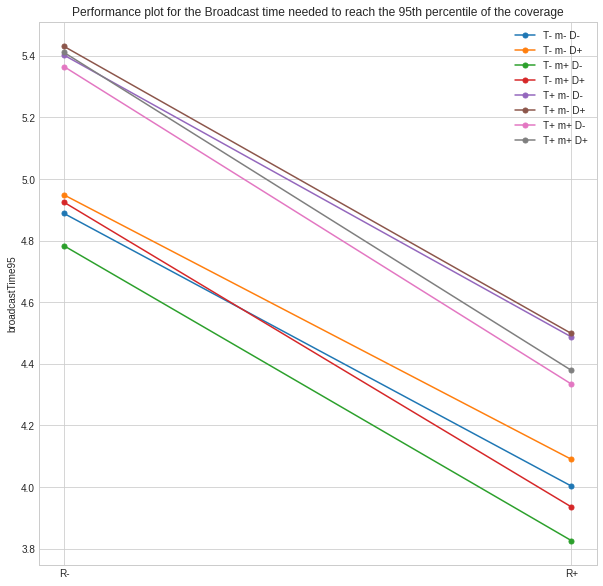

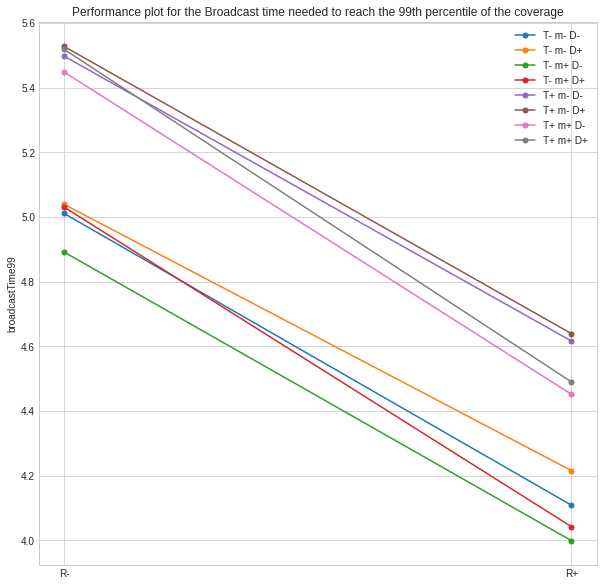

###########################

Plotting with T on the x axis...


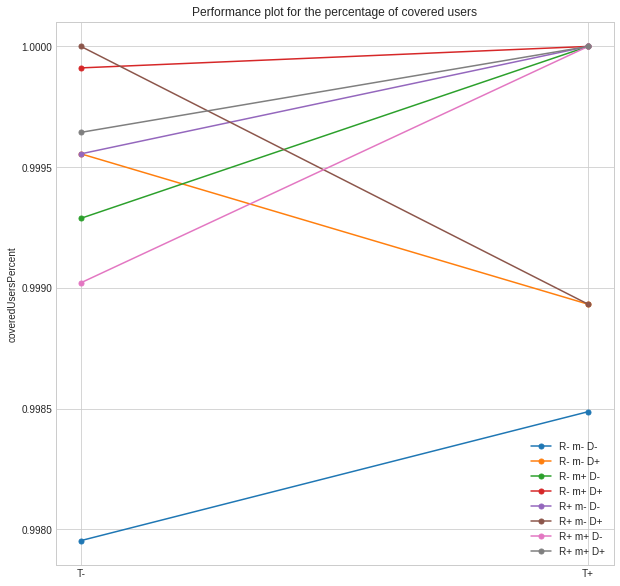

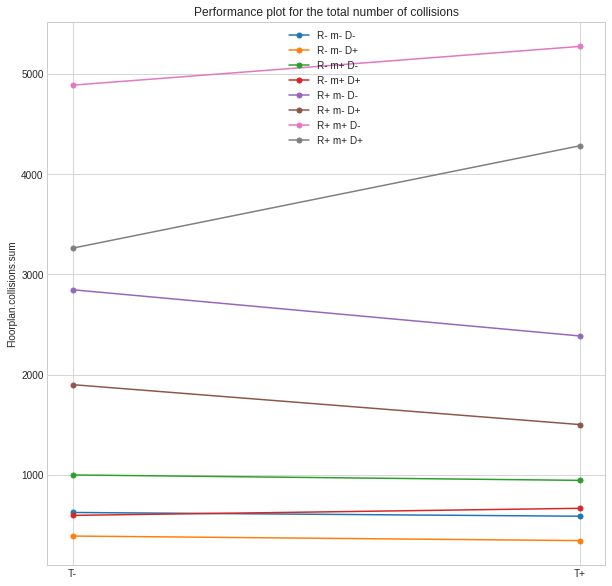

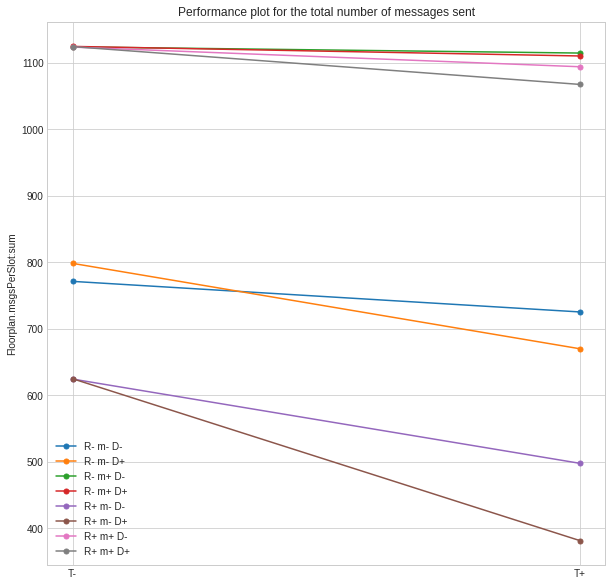

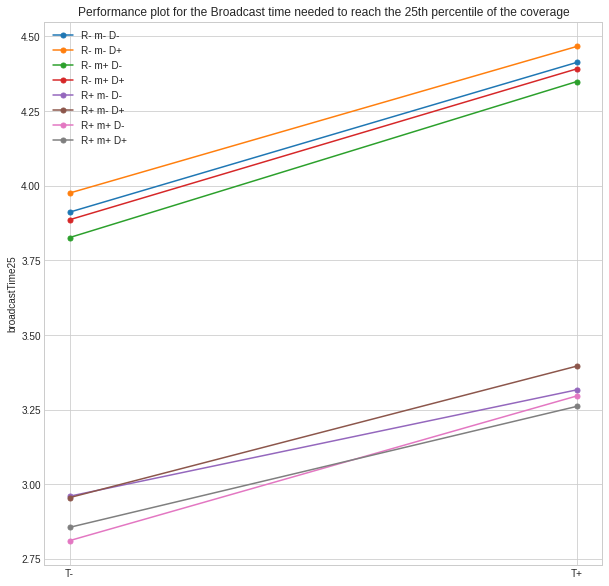

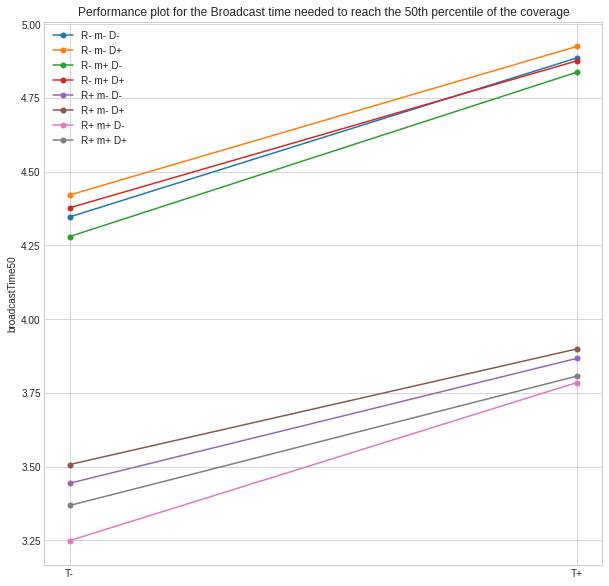

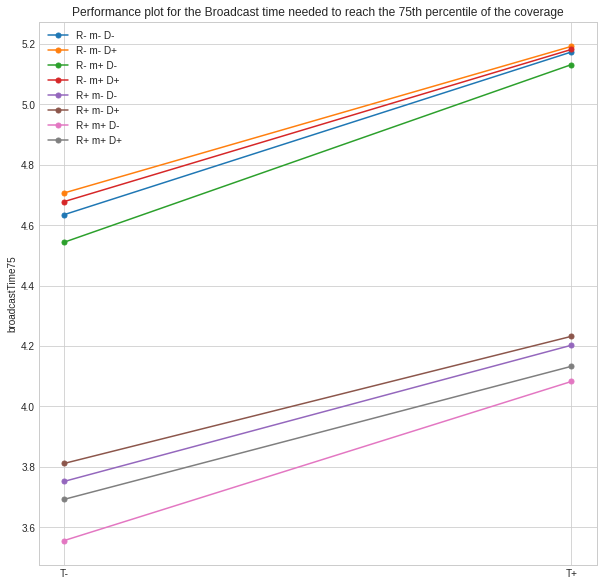

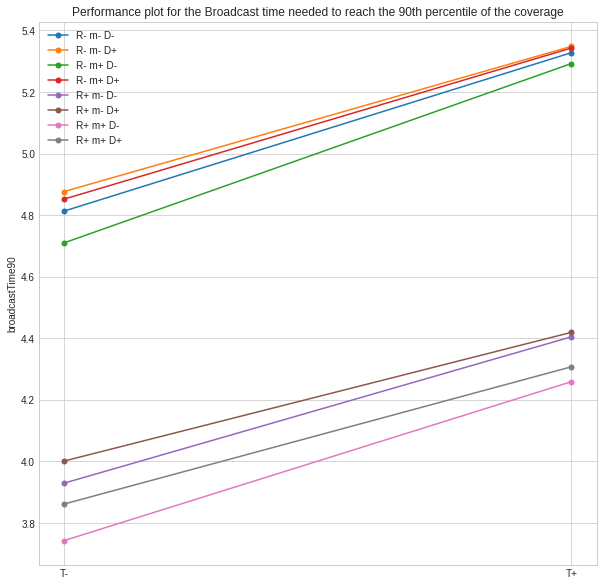

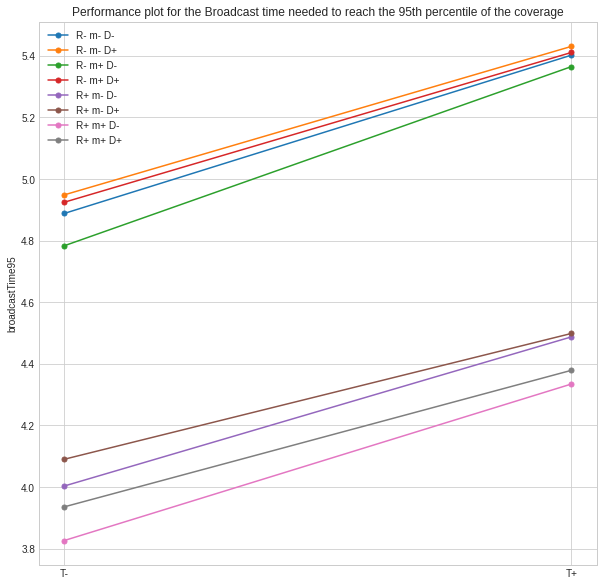

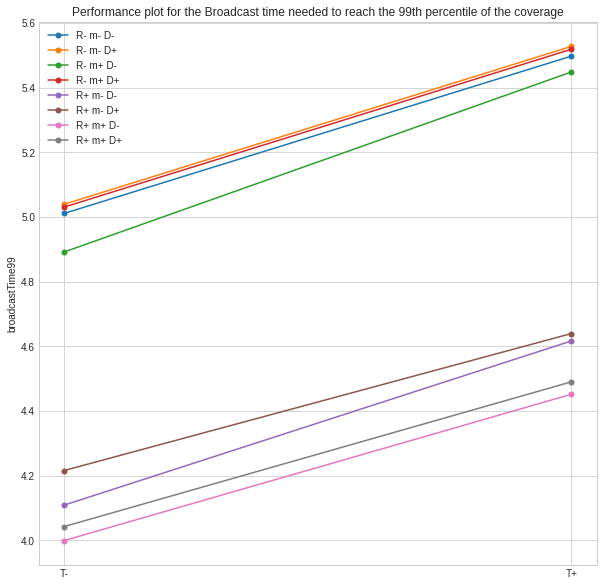

###########################

Plotting with m on the x axis...


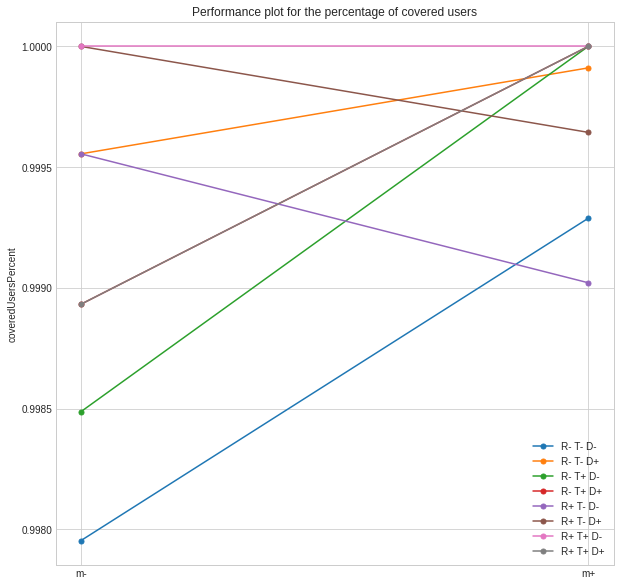

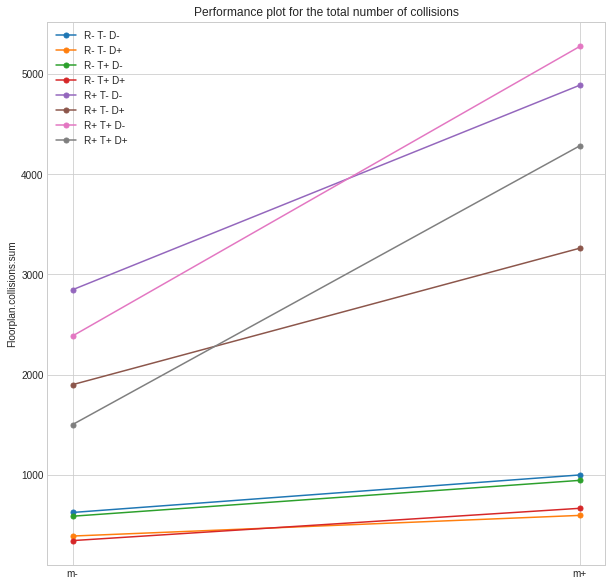

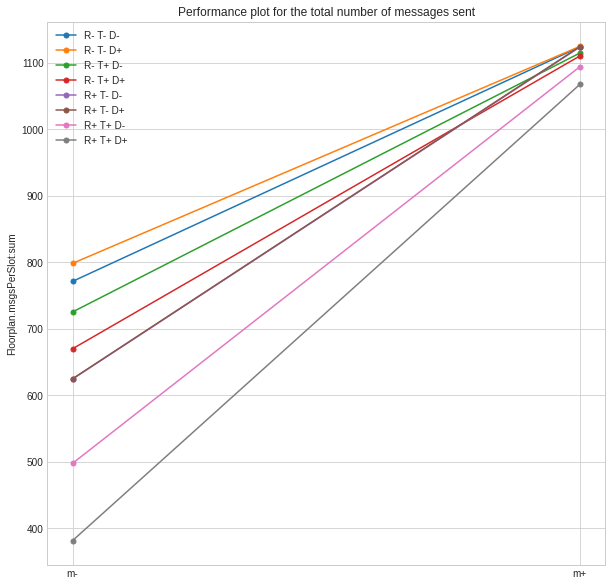

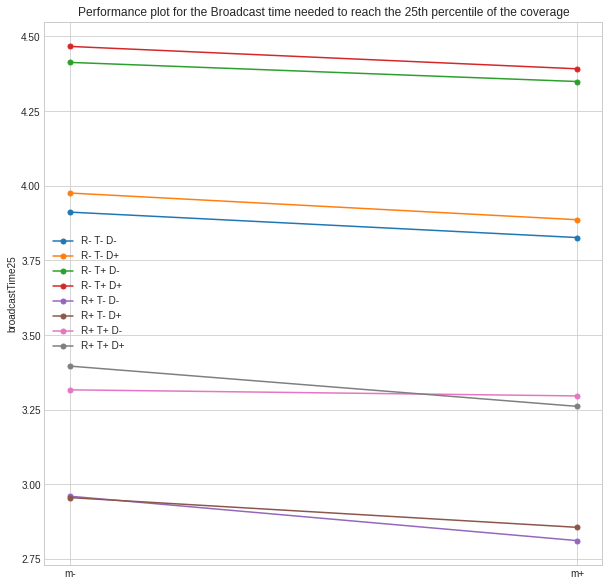

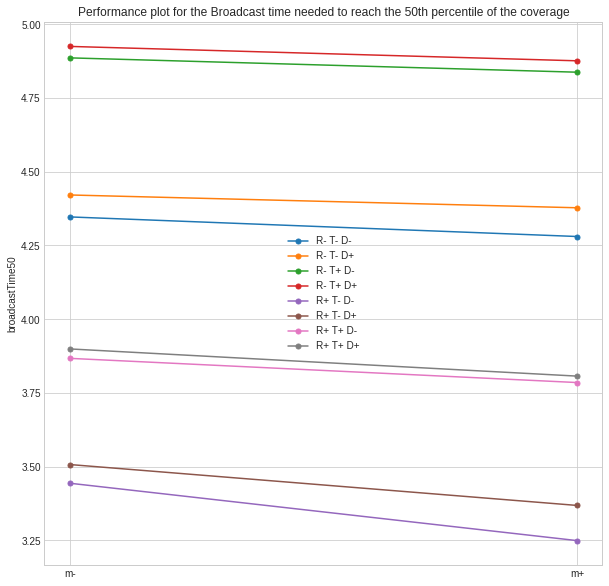

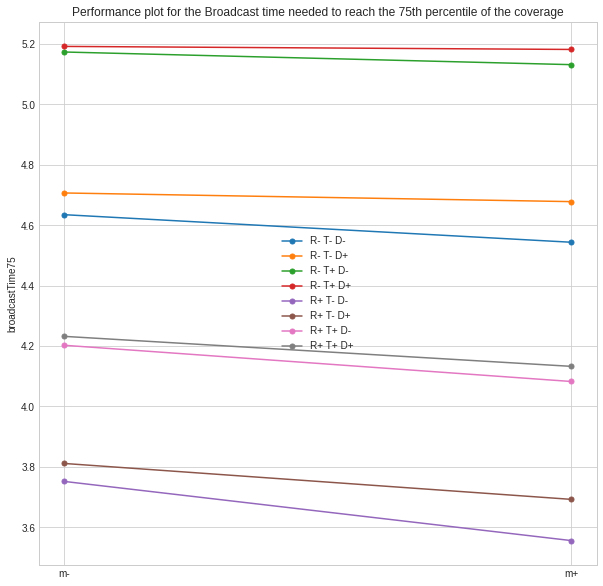

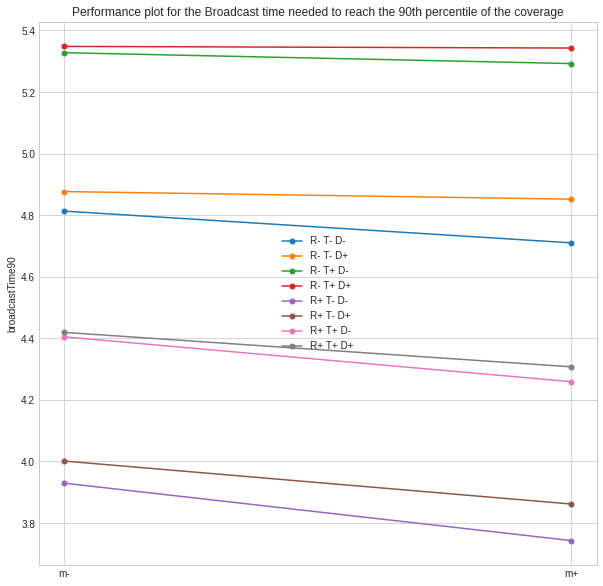

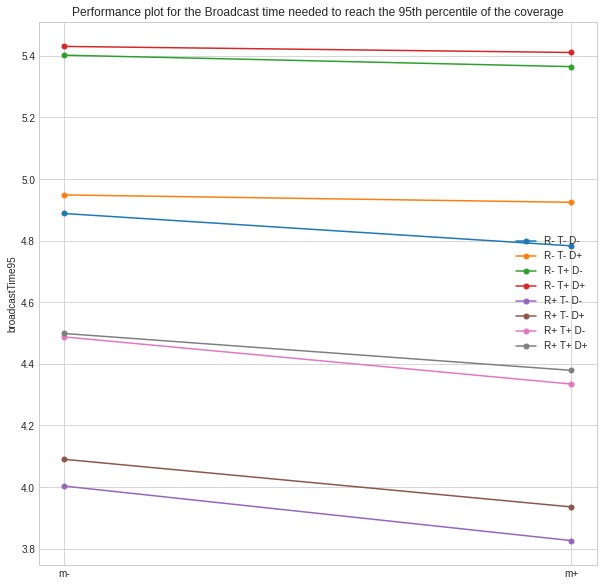

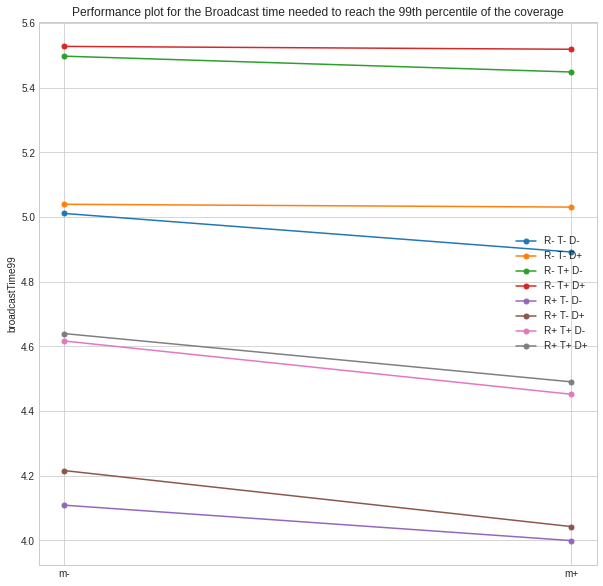

###########################

Plotting with D on the x axis...


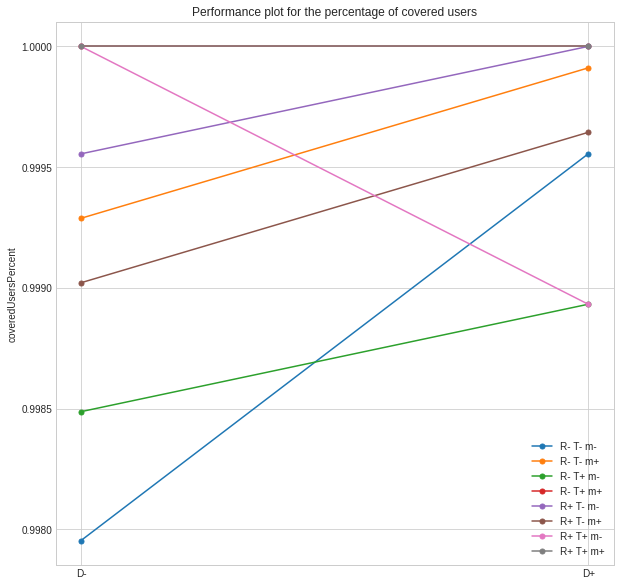

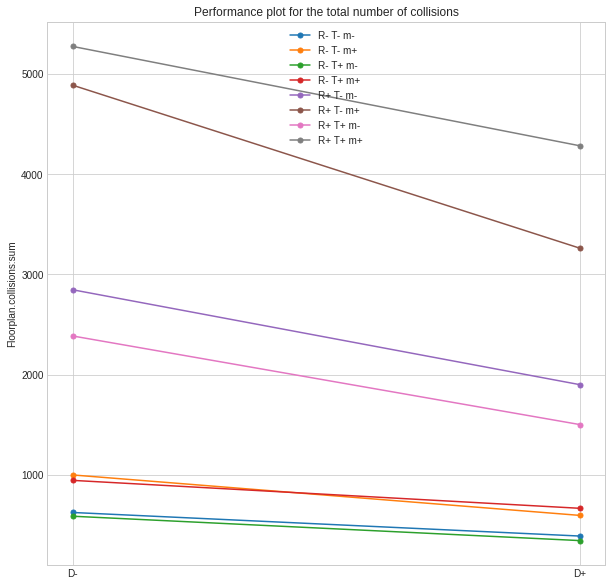

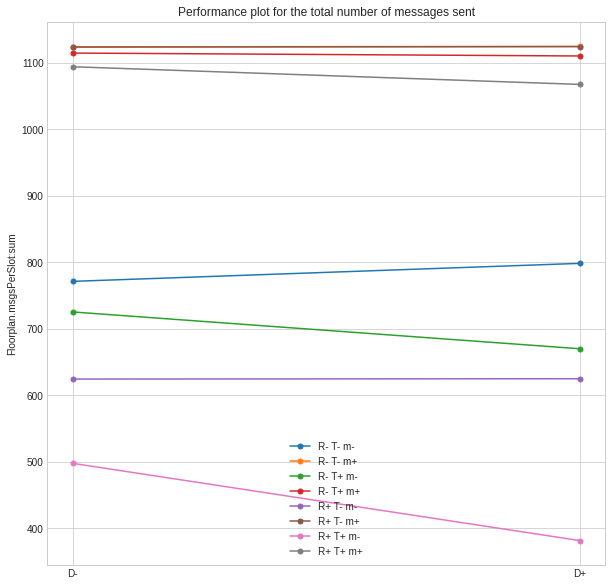

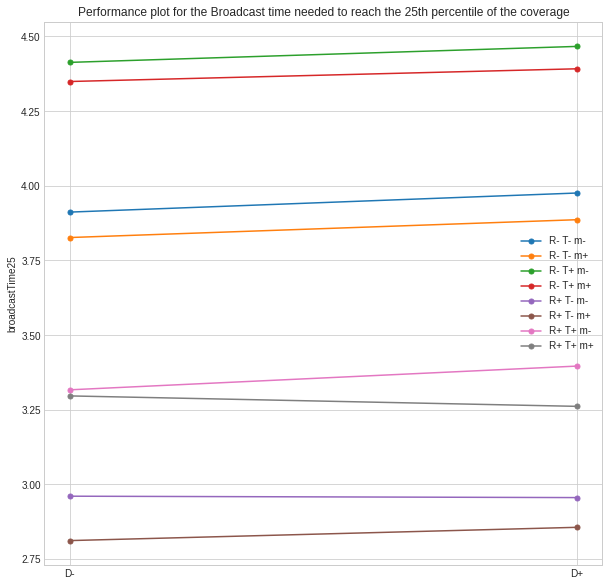

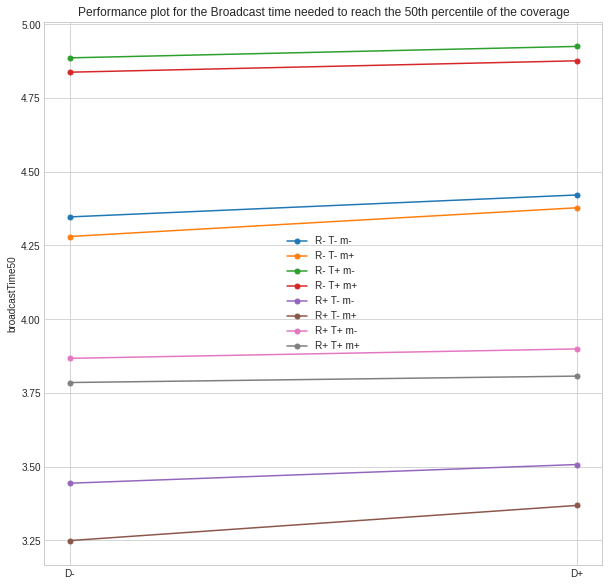

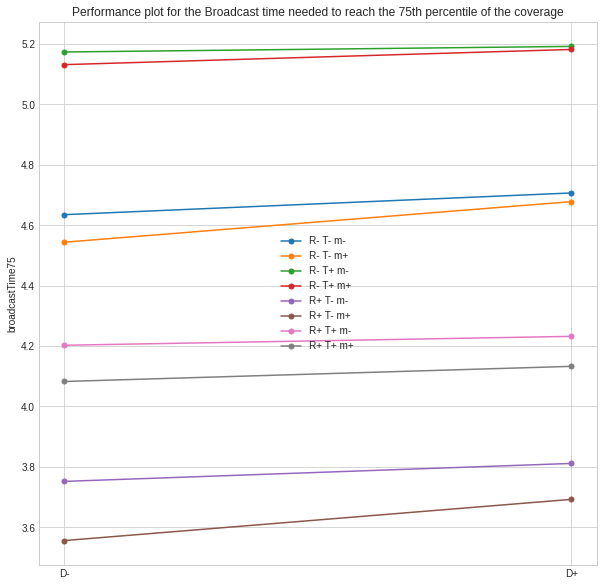

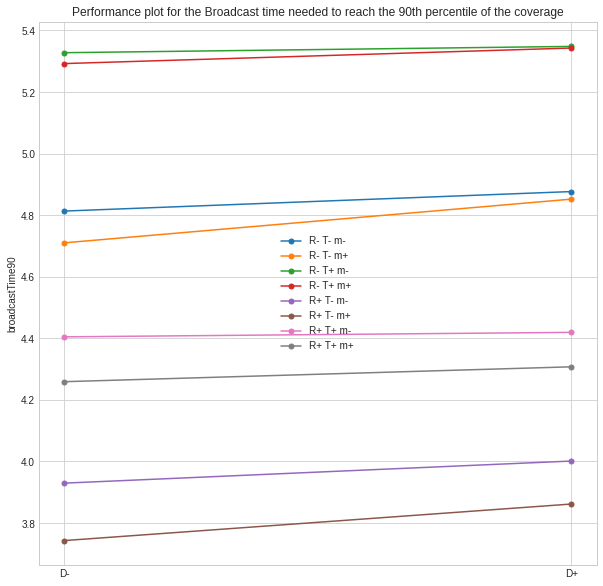

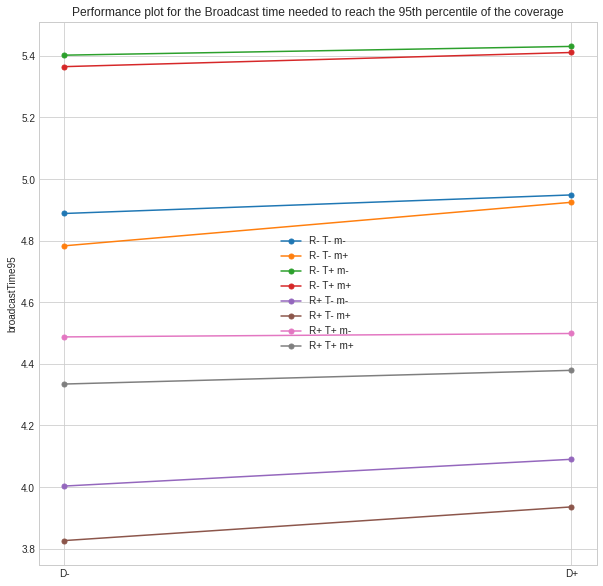

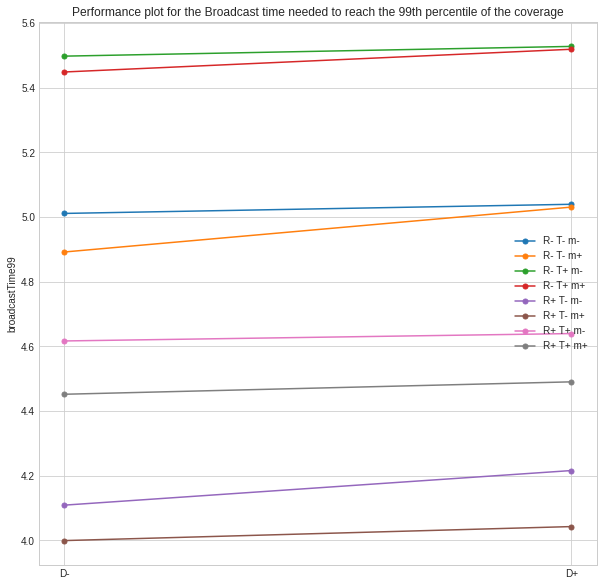

###########################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(perfIndex) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()

## Notes

First, it is worth noting that in this scenario we are always able to reach the 99% of the coverage. This allows us to study the broadcast time needed to reach the 99% of the network. As we can see from the tables above, the lowest coverage reached is 99.2883% (found in 2 experiments): this percentage means that 1116 out of 1124 reachable users (not counting the first one) has been reached; only 8 nodes have not heard the message.

So, in this scenario, we will not study the coverage since it is always almost perfect and so there is no need to optimize the parameters to increase the coverage.

#### Collisions

Regarding the total number of collisions, we get a low unexplained variation (0.67%). The most important factor is the broadcast radius (`R`, 66.27%), followed by the maximum number of copies (`m`, 15.76%) and the max relay delay (`D`, 4.64%). Combination of the broadcast radius with the maximum number of copies (`Rm`) has an influence of 9.01%. Other combinations have little or no effect on the number of collisions.

So, to reduce the total number of collisions, we can cleary state that it is necessary to reduce the broadcast radius and/or decrease the maximum number of copies. Also increasing the max relay delay may be useful.

#### Messages sent

For the total number of messages sent, which affects the energy efficiency of the network, we have a very low unexplained variation (0.53%). The most important factor is the maximum number of copies (`m`, 85.98%), followed by the broadcast radius (`R`, 4.85%). Combinations of the `R` and `m` factors are also important (`Rm`, 3.57%). Also the size of the hear window (`T`) and its combination with the maximum number of copies (`Tm`) have a little influence on the number of messages sent (`T`: 2.57%; `Tm`: 1.13%).

To reduce the total number of messages sent, it is useful to decrease the maximum number of copies. Also, the broadcast radius can be increased to reduce the number of messages sent, but it works only with low values of `m` as we can see from the performance plot. Also increasing the hear window size can be useful to decrease the number of messages sent, but only if `m` is low.

#### Broadcast time

For the broadcast time, we can see that we generally get an higher unexplained variation, up to 10.76% for the 25th percentile of the coverage. For the 99th percentile of the coverage we get an unexplained variation of 7.95%. So the unexplained variation decreases when the broadcast time is measured for an higher percentile of the coverage: this is expected since random factors that may affect the broadcast time will "shade away" on the long run.

Since we always reach the 99th percentile of the coverage, there is no reason to study the broadcast time for lower percentiles. So we will study this only for the 99% of the coverage.

The reason for the still high unexplained variation can been understood if we think that there is a factor that we (deliberately) do not take into analysis: the *placement* of the user in the 2D floorplan that sends the first message. We will not study this factor here since it is quite hard to analyze it in a 2kr factorial analysis, but we will discuss it in another scenario. To understand why the placement of the first sending user is important first imagine to place it on the center of the 2D floorplan: since the message is sent out radiusly from the user, he can reach other users in each direction around himself (360 degrees angle). If instead we place the first sending user in the corner of the 2D floorplan, the message that it sends out can reach other users only in a quarter of the area compared to the previous case (90 degrees angle). This changes the total broadcast time since, in the second case, the initial phase of the message's spreading is slower.

We can see that, for the total broadcast time, the most important factor is the broadcast radius (`R`, 71.25%), followed by the hear window size (`T`, 19.30%). Other factors and their combinations are irrelevant.

From the performance plots, we can see that to reduce the total broadcast time it is useful to increase the broadcast radius and/or decrease the hear window size.

We must note that for the total broadcast time we have used a *logarithmic transformation of the predicted variable* in order to meet the assumption of finite variance for the residuals (see `2kr-assumptions-tests.ipynb`).